In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import ee
import xee
import geemap
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
from shapely.geometry import box
from scipy.signal import savgol_filter
import rasterio
from rasterio.features import rasterize
from osgeo import gdal
import rioxarray

from func_mask import get_s2, add_cld_shdw_mask, apply_mask, addNDVI
from func_processing import time_series, ts_telcirkel_per_jaar, bare_soil_calc, bare_soil_format


In [26]:
try:
    #ee.Initialize()
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
except:
    ee.Authenticate(project='ee-katovanpoucke')

## Settings

In [2]:
# Voor twee jaar
start = '2021-11-01' # iets langer dan period of interest zodat we kunnen interpoleren
end = '2024-01-15'

start_wdw = '2022-02-01' # de echte period of interest
end_wdw = '2023-09-01'

vi_str = 'bsi' # welke vegetatie-index
sg_filter = True # gebruik van een Savitzky-Golay filter 

output_folder = 'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/rasters-telcirkels'
export = True

## Reading geometries (telcirkels)
Processing of the geometries was done in R script 01-process-geometries.R. Outputs were written to shared Q-drive. These processed geometries are now loaded here, so that they can be used in xarray earth engine. The counting points stay the same over the years, this means that we will download the required imagery for all years we want (e.g. 2022 and 2023) at the same time.

In [13]:
#Read telcirkels
#  CRS to 4326!!

tc = gpd.read_file('../data/processed/steekproef_mbag_mas.gpkg')
tc = tc.to_crs(epsg=4326)
tc.head(5)

,pointid,sample_order,batch,regio,area_prop_sb,openheid_klasse,sbp,crs,geometry
0,Km_10015,238,eerste set,Kempen,0.006130,HOL,binnen,31370,"POLYGON ((5.42787 51.11650, 5.42787 51.11636, ..."
1,Km_10019,1,eerste set,Kempen,0.001557,HOL,binnen,31370,"POLYGON ((5.46512 51.10721, 5.46511 51.10707, ..."
2,Km_10056.3,5,eerste set,Kempen,0.000000,HOL,binnen,31370,"POLYGON ((5.42861 51.06523, 5.42860 51.06509, ..."
3,Km_10565.2.3,201,eerste set,Kempen,0.000000,HOL,binnen,31370,"POLYGON ((4.88856 50.97978, 4.88856 50.97964, ..."
4,Km_10577.3,13,eerste set,Kempen,0.000000,HOL,binnen,31370,"POLYGON ((4.87989 50.99397, 4.87988 50.99383, ..."


In [14]:
## testje
#tc = tc.loc[tc.pointid.isin(['Lm_11070','Lm_11568.1','Lm_15064.9', 'Lm_8486.3', 'Lm_8898.1.8', 'Lm_9709.1.6', 'Zn_10111.7', 'Zn_10583.5', 'Zn_11411.7'])]
tc.loc[tc.pointid.isin(['Lm_11070','Lm_11568.1','Lm_15064.9', 'Lm_8486.3', 'Lm_8898.1.8', 'Lm_9709.1.6'])]
tc = tc.reset_index(drop=True)


## Processing for-loop
- Getting time series for every counting point, for all years at once
- Exporting them

In [40]:
# Loop over every telcirkel, for each one, data
sg_name = '_sg' if sg_filter == True else ''

for i in range(tc.shape[0]): #
    # create a bbox and convert to right format for extracting time series
    pointid = tc.loc[i,'pointid']
    shape = tc.loc[i,'geometry']


    # Create time series with custom function
    da = time_series(start, end, start_wdw, end_wdw, shape, vi_arg = vi_str, sg = sg_filter) #input= 'EPSG:4326', output = 'EPSG:32631'
    da.rio.set_spatial_dims('X', 'Y', inplace=True)

    #-- EXPORT
    if export == True:
        # Rename dimensions to conform to rioxarray requirements
        da = da \
        .rename({'Y': 'y', 'X': 'x'}) \
        .transpose('time', 'y', 'x') \
        .rio.write_crs("EPSG:32631")


        # Specify the output file path & export as GTiff

        output_file = f'multiband_raster_{vi_str}_{pointid}{sg_name}.tif'
        output_path = os.path.join(output_folder, output_file)
        da.rio.to_raster(output_path, driver='GTiff', tiled=True, compress='LZW')

        # Band renaming with GDAL (to store the dates)
        gdal.UseExceptions()

        # Define band names (these should be in the order of your bands)
        band_names = [str(time).split('T')[0] for time in da.time.values]

        # Open the dataset in update mode
        dataset = gdal.Open(output_path, gdal.GA_Update)

        if dataset:
            for i, name in enumerate(band_names, start=1):
                band = dataset.GetRasterBand(i)
                if band:
                    band.SetDescription(name)  # Set the band name

            dataset = None  # Close the dataset to flush changes
        else:
            print("Error opening file")

crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631


## Bare soil analysis
Eerst de weggeschreven rasters terug inladen op de juiste manier (time index valt onder andere weg blijkbaar). Daarna op de ingeladen data de *bare soil analysis* doen. De analyse op de weggeschreven rasters doen gaat veel sneller dan het rechtstreeks uit te voeren wanneer de data van earth engine komt! De *bare soil analysis* moet per jaar apart gebeuren met de bijbehorende landbouwgebruikspercelen, terwijl de rasters gedownload zijn voor verschillenden jaren tegelijk. In deze analyse moet dus andere polygonen gebruikt worden afhankelijk van het jaar.

<Axes: >

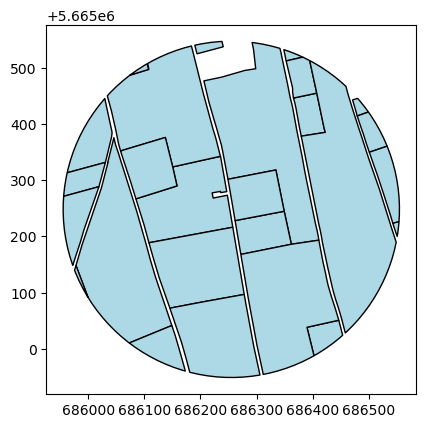

In [4]:
# Reading in all the parcels from Z-/Q-schijf and combining into one 
gdf_2022 = gpd.read_file('Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/landbouwgebruikspercelen_cut_bo_2022_clip.gpkg').to_crs(32631)
gdf_2023 = gpd.read_file('Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/landbouwgebruikspercelen_cut_bo_2023_clip.gpkg').to_crs(32631)

gdf_2022.head(5)

# Dictionary met de geodataframes per jaar (aanpassen als je meer of minder jaren wilt, moet natuurlijk binnen het tijdsbereik waarvoor er rasters gedownload zijn)
analysis_years_dict = {2022: gdf_2022, 2023: gdf_2023}

# CRS should be 4326
gdf_2022.loc[(gdf_2022.pointid == 'Km_26663.17')].plot(color='lightblue', edgecolor='black', linewidth=1)

In [5]:
#-- Polygon aggregation
# Create empty dataframe for storage results (polygon-aggregated time series)
df_ts = pd.DataFrame(columns=['REF_ID', 'pointid', 'time', 'ndvi'])

raster_files = os.listdir(output_folder)

for file in raster_files:
    print(file)
    
    # Open the raster file
    raster = rioxarray.open_rasterio(os.path.join(output_folder,file))

    # Extract dates from the 'long_name' attribute, convert to datetime & assign to 'band' coordinate
    dates = [raster.attrs['long_name'][i] for i in range(len(raster.band))]
    time_index = pd.to_datetime(dates)
    raster['band'] = time_index


    # Xarray settings
    raster = raster.rename({'band': 'time', 'x' : 'X', 'y': 'Y'}).transpose('time', 'X', 'Y')
    raster = raster.rio.set_spatial_dims('X','Y')
    raster.rio.write_crs("EPSG:32631", inplace=True)

    # Extract pointid
    # pointid moet overeenkomen met de raster waarvoor de data opgehaald wordt, anders probleem met geen overlap tussen raster en polygon
    if sg_filter == False:
        pointid = file.lstrip('multiband_raster_').rstrip('_test.tif')
    elif sg_filter == True:
        pointid = file.lstrip(f'multiband_raster_{vi_str}').rstrip('_sg.tif')
        
    # In deze for-loop worden de tijdsreeksen voor het telpunt per jaar apart toegevoegd; afhankelijk van de geodataframes die in de dictionary zitten
    for year, gdf_year in analysis_years_dict.items():
        df_ts = ts_telcirkel_per_jaar(raster=raster, gdf=gdf_year, year=year, pointid=pointid, df_ts=df_ts)

df_ts = df_ts.sort_values(by = ['pointid','REF_ID','time']).reset_index(drop=True)
df_ts = df_ts[['pointid', 'REF_ID', 'time', 'ndvi']]
df_ts.to_csv('../outputs/output_analysis/time_series.csv')

df_ts

multiband_raster_ndvi_Km_10015_sg.tif
multiband_raster_ndvi_Km_10019_sg.tif
multiband_raster_ndvi_Km_10056.3_sg.tif
multiband_raster_ndvi_Km_10565.2.3_sg.tif
multiband_raster_ndvi_Km_10577.3_sg.tif
multiband_raster_ndvi_Km_10810.1_sg.tif
multiband_raster_ndvi_Lm_11070_sg.tif
multiband_raster_ndvi_Lm_11568.1_sg.tif
multiband_raster_ndvi_Lm_15064.9_sg.tif
multiband_raster_ndvi_Lm_8486.3_sg.tif
multiband_raster_ndvi_Lm_8898.1.8_sg.tif
multiband_raster_ndvi_Lm_9709.1.6_sg.tif
multiband_raster_ndvi_Zn_10111.7_sg.tif
multiband_raster_ndvi_Zn_10583.5_sg.tif
multiband_raster_ndvi_Zn_11411.7_sg.tif


,pointid,REF_ID,time,ndvi
0,Km_10015,403232939,2022-02-01,0.131130
1,Km_10015,403232939,2022-02-11,0.211103
2,Km_10015,403232939,2022-02-21,0.275849
3,Km_10015,403232939,2022-03-03,0.334228
4,Km_10015,403232939,2022-03-13,0.351813
...,...,...,...,...
20415,Zn_11411.7,2320375089,2023-07-16,0.634000
20416,Zn_11411.7,2320375089,2023-07-26,0.598350
20417,Zn_11411.7,2320375089,2023-08-05,0.580685
20418,Zn_11411.7,2320375089,2023-08-15,0.585071


Ik gok dat string *index out of range* komt doordat ik het downloaden van de rasters vroegtijdig heb afgebroken, waardoor in de DataArray'long_name' als 'ndvi' gebleven is en niet de datums die het moeten zijn. Ik denk dus dat het geen probleem is in de code.

In [6]:
# Formatting before bare soil calculation
# This format & the calculation should be changed if it turns out that it is too heavy for processing
gdf_ts_2022 = bare_soil_format(df_ts, gdf_2022, 2022)
gdf_ts_2023 = bare_soil_format(df_ts, gdf_2023, 2023)


# Bare soil calculation
result = bare_soil_calc(gdf_ts_2022)
result.to_csv('../outputs/output_analysis/bare_soil_analysis_2022_v3.csv')

result = bare_soil_calc(gdf_ts_2023)
result.to_csv('../outputs/output_analysis/bare_soil_analysis_2023_v3.csv')

result.head(5)

#gdf_ts[['OIDN', 'pointid', 'date', 'ndvi','geometry']].head(3)
#gdf.loc[~gdf.OIDN.isin(gdf_ts.OIDN.unique().tolist())].to_file('../outputs/empty_geometries.gpkg')

,pointid,year,period,% bare soil
0,Km_10015,2023,R1,0.499656
1,Km_10019,2023,R1,29.591673
2,Km_10056.3,2023,R1,9.964779
3,Km_10565.2.3,2023,R1,46.105010
4,Km_10577.3,2023,R1,4.102443


In [32]:
result.pointid.value_counts()

pointid
Km_10015        4
Km_10019        4
Km_10056.3      4
Km_10565.2.3    4
Km_10577.3      4
Km_10810.1      4
Name: count, dtype: int64

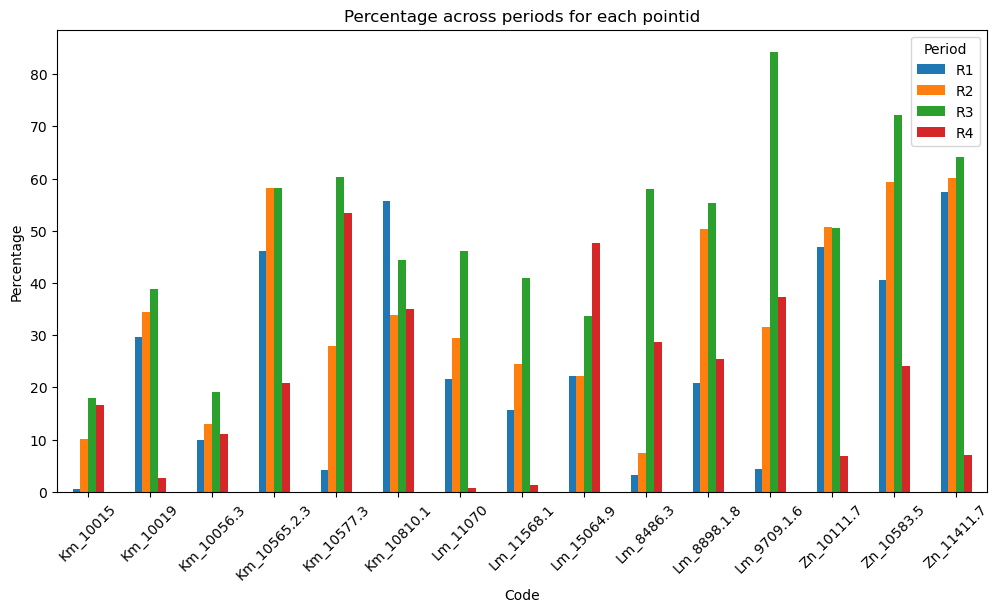

In [ ]:
pd.read_csv('../outputs/output_analysis/bare_soil_analysis_2022_v3.csv')